In [102]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import minimize
import pickle

import warnings
warnings.filterwarnings('ignore') # 경고 메세지 OFF


#### 공분산 행렬 ∑ 구하기

In [103]:
BTC = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/비트코인 과거 데이터.csv")
ETH = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/이더리움 과거 데이터.csv")
BNB = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/BNB 과거 데이터.csv")
DOT = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Polkadot 과거 데이터.csv")
SOL = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Solana 과거 데이터.csv")
FTT = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/FTX Token 과거 데이터.csv")
XRP = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/XRP 과거 데이터.csv")
UNI = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Uniswap 과거 데이터.csv")

In [104]:
# 날짜 범위 정의
start_date = pd.to_datetime('2023-01-01')
end_date = pd.to_datetime('2023-12-31')

# 데이터프레임과 티커 이름을 매핑
ticker_dfs = {'BTC':BTC, 'ETH': ETH, 'BNB': BNB, 'DOT': DOT, 'SOL': SOL, 'FTT': FTT, 'XRP':XRP,'UNI':UNI}

# 각 데이터프레임을 처리하고 결과를 저장
filtered_dfs = {}
for ticker, df in ticker_dfs.items():
    # 필요없는 열 삭제
    
    del df['고가']
    del df['시가']
    del df['저가']
    del df['거래량']
    del df['종가']
    # 날짜 열을 datetime 객체로 변환
    df['created_at'] = pd.to_datetime(df['날짜'])
    del df['날짜']
    df['변동 %'] = df['변동 %'].str.replace('%', '').astype(float)
    # 주어진 날짜 범위에 맞게 필터링
    filtered_df2 = df[(df['created_at'] >= start_date) & (df['created_at'] <= end_date)]
    filtered_df2.reset_index(drop=True, inplace=True)

    # 필터링된 데이터프레임을 딕셔너리에 저장
    filtered_dfs[ticker] = filtered_df2


#### rolling window = 90일 (약 3개월)

In [105]:
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
returns = pd.DataFrame(index=all_dates)

# 각 크립토의 '변동 %' 데이터를 새로운 데이터프레임에 추가
for ticker, df in filtered_dfs.items():
    df.set_index('created_at', inplace=True)  # 'created_at'을 인덱스로 설정
    df = df.reindex(all_dates)  # 모든 날짜에 대해 데이터프레임을 재정렬
    returns[ticker] = df['변동 %']
    
# 상관 계수 행렬    
total_corr_matrix = returns.corr()

# 롤링 창을 정의 (3개월, 대략 90일)
rolling_window = 90

# 날짜별로 공분산 행렬을 저장할 딕셔너리를 초기화
rolling_cov_matrices = {}

# 날짜별로 롤링 창을 적용하여 공분산 행렬을 계산
for end_date in pd.date_range(start='2023-06-01', end='2023-12-31'):
    start_date = end_date - pd.Timedelta(days=rolling_window)
    rolling_window_df = returns[(returns.index >= start_date) & (returns.index <= end_date)]
    rolling_cov_matrices[end_date] = rolling_window_df.cov()

# 결과 확인 (특정 날짜의 공분산 행렬 예시 출력)
rolling_cov_matrices[pd.to_datetime('2023-06-01')]

,BTC,ETH,BNB,DOT,SOL,FTT,XRP,UNI
BTC,7.056542,5.999678,4.187979,6.356822,7.165662,5.433051,4.284108,6.133995
ETH,5.999678,7.167361,3.756809,6.627809,7.132545,6.480126,5.264504,6.936754
BNB,4.187979,3.756809,4.541043,4.248445,4.596897,3.115467,2.630189,3.598256
DOT,6.356822,6.627809,4.248445,8.644491,8.900499,6.623212,6.167611,7.825017
SOL,7.165662,7.132545,4.596897,8.900499,13.453610,11.324153,5.855566,8.607845
FTT,5.433051,6.480126,3.115467,6.623212,11.324153,96.410120,4.864179,8.496966
XRP,4.284108,5.264504,2.630189,6.167611,5.855566,4.864179,15.797300,6.230843
UNI,6.133995,6.936754,3.598256,7.825017,8.607845,8.496966,6.230843,9.386485


In [106]:
rolling_cov_matrices[pd.to_datetime('2023-06-07')]

,BTC,ETH,BNB,DOT,SOL,FTT,XRP,UNI
BTC,7.518721,6.316207,4.944566,6.553320,7.749243,5.421072,5.056206,6.324668
ETH,6.316207,7.382232,4.355233,6.748802,7.621945,6.420453,5.878632,7.066907
BNB,4.944566,4.355233,6.058457,4.867666,6.082451,3.689109,3.463472,4.346047
DOT,6.553320,6.748802,4.867666,8.640445,9.129247,6.232481,6.773492,7.816572
SOL,7.749243,7.621945,6.082451,9.129247,14.260396,11.352234,7.120777,8.975412
FTT,5.421072,6.420453,3.689109,6.232481,11.352234,95.901329,6.065219,8.133680
XRP,5.056206,5.878632,3.463472,6.773492,7.120777,6.065219,16.397286,6.849676
UNI,6.324668,7.066907,4.346047,7.816572,8.975412,8.133680,6.849676,9.273910


#### 상관계수 행렬(2023.06.01 ~ 2023.12.31 기간의 평균)

In [107]:
total_corr_matrix

,BTC,ETH,BNB,DOT,SOL,FTT,XRP,UNI
BTC,1.000000,0.826453,0.622888,0.674377,0.609722,0.269420,0.397313,0.577548
ETH,0.826453,1.000000,0.640357,0.670241,0.609124,0.327955,0.468341,0.660816
BNB,0.622888,0.640357,1.000000,0.588668,0.481504,0.196798,0.353828,0.550025
DOT,0.674377,0.670241,0.588668,1.000000,0.688124,0.275992,0.412441,0.675656
SOL,0.609722,0.609124,0.481504,0.688124,1.000000,0.454210,0.387294,0.569024
FTT,0.269420,0.327955,0.196798,0.275992,0.454210,1.000000,0.100917,0.264161
XRP,0.397313,0.468341,0.353828,0.412441,0.387294,0.100917,1.000000,0.418304
UNI,0.577548,0.660816,0.550025,0.675656,0.569024,0.264161,0.418304,1.000000


### H : the vector of implied excess-returns(내재수익률) 구하기
#### H=λΣx(Benchmark)
##### λ = 1 

("xBenchmark is set to the global minimum-variance portfolio as in Bessler et al. (2017), and many others. Since we maximize the Sharpe ratio, the parameter λ is set to unity.")

#### x(Benchmark) = Minimum Variance Portfolio 구하기

### 라그랑주 함수
라그랑주 함수 \( L \)는 다음과 같이 정의됩니다:

$$
L(w, \lambda) = w^T \Sigma w - \lambda \left( \sum_{i} w_i - 1 \right)
$$

여기서 $$\lambda $$ 는 라그랑주 승수이며, 제약 조건 $$\sum_{i} w_i = 1\ $$을 반영합니다.

### 최적화
이제 \( L \)을 \( w \)와 \( \lambda \)에 대해 미분하여 최적 조건을 찾습니다. 먼저 \( w \)에 대해 미분합니다:

$$
\frac{\partial L}{\partial w} = 2 \Sigma w - \lambda \mathbf{1} = 0
$$

여기서 \( \mathbf{1} \)은 모든 요소가 1인 벡터입니다. 이 식을 \( w \)에 대해 정리하면:

$$
w = \frac{1}{2} \Sigma^{-1} \lambda \mathbf{1}
$$

다음으로, \( \lambda \)에 대해 미분하고, 조건 \( \sum_{i} w_i = 1 \)을 사용하여 \( \lambda \)를 구합니다:

$$
\frac{\partial L}{\partial \lambda} = -\sum_{i} w_i + 1 = 0
$$

$$
\Rightarrow \sum_{i} w_i = 1
$$

이를 위의 \( w \)에 대한 식에 대입하여 \( \lambda \)를 구합니다. 이를 통해 최종 가중치 \( w \)를 구할 수 있습니다.


In [108]:
# 모든 기간 동안의 최소 변동성 포트폴리오 가중치 계산을 위한 코드

# 가중치를 저장할 딕셔너리
min_variance_weights = {}

# 각 날짜에 대해 최소 변동성 포트폴리오 가중치 계산
for date in rolling_cov_matrices.keys():
    cov_matrix = rolling_cov_matrices[date]
    
    # 공분산 행렬의 역행렬 계산
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    # 모든 자산에 대해 1을 포함하는 벡터 생성
    ones = np.ones(len(inv_cov_matrix))

    # 라그랑주 승수법을 사용하여 가중치 계산
    weights = inv_cov_matrix.dot(ones) / ones.dot(inv_cov_matrix).dot(ones)

    # 결과 저장
    min_variance_weights[date] = weights

# 결과 확인 (2023-12-31의 가중치 예시 출력)
min_variance_weights[pd.to_datetime('2023-12-31')]



array([ 0.49371237,  0.0680383 ,  0.29831767, -0.05120927, -0.06359903,
        0.00356313,  0.25560524, -0.0044284 ])

#### 가중치는 0 보다 크거나 같아야 함 => 제약 조건 추가

In [109]:
def min_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

def get_min_variance_weights(cov_matrix):
    num_assets = len(cov_matrix)
    initial_guess = np.ones(num_assets) / num_assets
    bounds = [(0, 1) for _ in range(num_assets)]
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    result = minimize(min_variance, initial_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

In [110]:
# 예시: 특정 날짜의 최소 변동성 포트폴리오 가중치 계산
cov_matrix = rolling_cov_matrices[pd.to_datetime('2023-12-21')]
weights = get_min_variance_weights(cov_matrix)
weights


array([3.04929199e-01, 9.77633733e-02, 4.25393871e-01, 6.28381800e-14,
       8.14489255e-14, 0.00000000e+00, 1.71913557e-01, 4.68991677e-14])

### H : the vector of implied excess-returns(내재수익률) 계산

#### H=λΣx(Benchmark)

In [111]:
lambda_value = 1  # 위험 회피 계수
H_vectors = {}  # 날짜별 H 벡터를 저장할 딕셔너리

for date in rolling_cov_matrices.keys():
    cov_matrix = rolling_cov_matrices[date]
    x_benchmark = get_min_variance_weights(cov_matrix)  # 여기서 괄호 사용
    H_vector = lambda_value * cov_matrix.dot(x_benchmark)
    H_vectors[date] = H_vector

# 결과 확인 (특정 날짜의 H 벡터 예시 출력)
H_vectors[pd.to_datetime('2023-12-31')]


BTC    3.813585
ETH    3.813585
BNB    3.813585
DOT    4.934640
SOL    5.837033
FTT    5.645042
XRP    3.813585
UNI    4.343151
dtype: float64

In [112]:
H_vectors[pd.to_datetime('2023-12-11')]

BTC    3.261918
ETH    3.261918
BNB    3.261918
DOT    4.023379
SOL    5.642051
FTT    4.653299
XRP    3.261918
UNI    4.409061
dtype: float64

### Ω 행렬 구하기

$$
\Omega = \frac{1}{\delta} P \Sigma P^T
$$

where 1/δ is set to unity(=1) as in Meucci (2010)

In [113]:
delta_value = 1  # where 1/δ is set to unity(=1) as in Meucci (2010)
Omega_Matrice = {} 
num_assets = len(cov_matrix)
P = np.eye(num_assets) # NxN 대각행렬 생성

for date in rolling_cov_matrices.keys():
    cov_matrix = rolling_cov_matrices[date]
    Omega_Matrix= (1 / delta_value) * P.dot(cov_matrix).dot(P.T)
    Omega_Matrice[date] = Omega_Matrix


Omega_Matrice[pd.to_datetime('2023-06-01')]

array([[ 7.05654234,  5.99967789,  4.187979  ,  6.35682187,  7.16566221,
         5.43305104,  4.28410753,  6.13399536],
       [ 5.99967789,  7.1673611 ,  3.75680888,  6.62780868,  7.13254543,
         6.48012593,  5.26450422,  6.9367536 ],
       [ 4.187979  ,  3.75680888,  4.54104332,  4.24844535,  4.59689654,
         3.11546705,  2.63018867,  3.59825582],
       [ 6.35682187,  6.62780868,  4.24844535,  8.64449092,  8.90049904,
         6.62321199,  6.16761071,  7.82501679],
       [ 7.16566221,  7.13254543,  4.59689654,  8.90049904, 13.45360989,
        11.32415267,  5.85556558,  8.60784491],
       [ 5.43305104,  6.48012593,  3.11546705,  6.62321199, 11.32415267,
        96.41012049,  4.86417904,  8.49696612],
       [ 4.28410753,  5.26450422,  2.63018867,  6.16761071,  5.85556558,
         4.86417904, 15.79730049,  6.23084261],
       [ 6.13399536,  6.9367536 ,  3.59825582,  7.82501679,  8.60784491,
         8.49696612,  6.23084261,  9.3864852 ]])

In [114]:
Omega_Matrice[pd.to_datetime('2023-12-21')]

array([[  5.09253741,   4.02205433,   2.4322041 ,   5.20411613,
          7.3298695 ,   7.6496283 ,   2.97134287,   4.5062922 ],
       [  4.02205433,   6.22552408,   2.67965256,   5.08627784,
          6.75474796,  11.25919249,   3.00470919,   5.59147066],
       [  2.4322041 ,   2.67965256,   4.75355316,   4.83251068,
          5.91350538,   4.23526701,   2.70926342,   4.32667983],
       [  5.20411613,   5.08627784,   4.83251068,  16.58504425,
         14.73677053,  11.63597847,   5.1613368 ,  10.06791989],
       [  7.3298695 ,   6.75474796,   5.91350538,  14.73677053,
         33.90778269,  42.02658098,   5.92623818,  11.534663  ],
       [  7.6496283 ,  11.25919249,   4.23526701,  11.63597847,
         42.02658098, 200.50266884,   1.34714015,  14.62578574],
       [  2.97134287,   3.00470919,   2.70926342,   5.1613368 ,
          5.92623818,   1.34714015,   6.62665067,   5.29475501],
       [  4.5062922 ,   5.59147066,   4.32667983,  10.06791989,
         11.534663  ,  14.6257857

#### 블랙리터만 포트폴리오 수익률 구하기

### 
$$
\mu_{BL} = \left[(c\Sigma)^{-1} + P^T \Omega^{-1} P \right]^{-1} \left[(c\Sigma)^{-1} H + P^T \Omega^{-1} Q \right]
$$

('We also follow Platanakis and Sutcliffe (2017) and set the parameter c, which represents the overall level of confidence in the implied asset returns, to 0.1625')

$c = 0.1625$

##### $Q$ (투자자 견해가 반영된 예상 수익률) 가져오기
##### from '/home/user/exercise_j/GPT Project/Sentiment-Portfolio-Asset-allocation/Crypto_ECM-LSTM/ECM-LSTM_V2_10000Tweets.ipynb'

In [115]:
# Q 벡터를 pickle 파일에서 불러오기
with open('q_vector.pkl', 'rb') as f:
    Q = pickle.load(f)

In [116]:
Q['ETH']

[[[0.06809842586517334]],
 [[0.06977349519729614]],
 [[0.052194222807884216]],
 [[0.05211959406733513]],
 [[0.051402680575847626]],
 [[0.054081760346889496]],
 [[0.06549876928329468]],
 [[0.06056344136595726]],
 [[0.06917645782232285]],
 [[0.070229172706604]],
 [[0.06674721837043762]],
 [[0.04867780581116676]],
 [[0.04295776039361954]],
 [[0.051804207265377045]],
 [[0.05933708697557449]],
 [[0.06483125686645508]],
 [[0.059102658182382584]],
 [[0.058033689856529236]],
 [[0.052924539893865585]],
 [[0.07010584324598312]],
 [[0.03297090902924538]],
 [[0.08049101382493973]],
 [[0.07162614911794662]],
 [[0.06636133044958115]],
 [[0.06844332814216614]],
 [[0.0491013303399086]],
 [[0.05468662083148956]],
 [[0.03983336314558983]],
 [[0.05947922542691231]],
 [[0.05170416086912155]],
 [[0.04068457707762718]],
 [[0.054725803434848785]],
 [[0.044901903718709946]],
 [[0.04113912954926491]],
 [[0.036324385553598404]],
 [[0.047669172286987305]],
 [[0.06067440286278725]],
 [[0.038519714027643204]],
 [[

#### 계산을 위해 알맞게 형태 변환

In [117]:
dates = pd.date_range(start='2023-06-01', end='2023-12-31')
# Q 딕셔너리를 DataFrame으로 변환
Q_df = pd.DataFrame.from_dict(Q, orient='index', columns=dates)

# [[]] 구조를 제거하고 단일 값으로 변환
for col in Q_df.columns:
    Q_df[col] = Q_df[col].apply(lambda x: x[0][0] if isinstance(x, list) and len(x) > 0 and isinstance(x[0], list) and len(x[0]) > 0 else x)

Q_df


,2023-06-01,2023-06-02,2023-06-03,2023-06-04,2023-06-05,2023-06-06,2023-06-07,2023-06-08,2023-06-09,2023-06-10,...,2023-12-22,2023-12-23,2023-12-24,2023-12-25,2023-12-26,2023-12-27,2023-12-28,2023-12-29,2023-12-30,2023-12-31
BTC,0.069148,0.068357,0.056369,0.061614,0.074483,0.055164,0.077118,0.075367,0.095014,0.074685,...,-0.028846,-0.003103,-0.003578,-0.024783,-0.019111,-0.031608,0.009679,0.011296,-0.004304,-0.005677
ETH,0.068098,0.069773,0.052194,0.052120,0.051403,0.054082,0.065499,0.060563,0.069176,0.070229,...,-0.016070,0.036365,0.051200,0.010292,0.011652,-0.000255,0.035434,0.037125,0.026768,0.025885
BNB,0.082978,0.089520,0.071055,0.057190,0.063989,0.040308,0.066435,0.053898,0.061929,0.051706,...,0.013692,0.052309,0.051247,0.037046,0.062104,0.050248,0.092209,0.090713,0.088571,0.087455
DOT,0.065217,0.071790,0.060592,0.071731,0.068410,0.062395,0.076304,0.043869,0.057723,0.060043,...,0.001284,0.026818,0.024303,0.024634,0.037021,0.021484,0.031875,0.031522,0.028263,0.028038
SOL,0.071685,0.071451,0.063690,0.050373,0.057988,0.051516,0.061380,0.046964,0.062355,0.041585,...,-0.041922,0.008202,0.021343,0.012168,0.012367,0.004647,0.022366,0.027355,0.024306,0.024683
FTT,0.047389,0.058944,0.052524,0.055019,0.063738,0.062033,0.067302,0.067668,0.067144,0.065170,...,0.019756,0.018765,0.008973,0.024405,0.025517,0.023323,0.025168,0.031907,0.029942,0.027716
XRP,0.038642,0.040194,0.034856,0.032696,0.034718,0.030672,0.034671,0.033030,0.038070,0.031003,...,-0.001239,0.014430,0.013628,0.006529,0.009583,-0.001010,0.017071,0.015982,0.012779,0.008333
UNI,0.065870,0.066699,0.057704,0.042088,0.047565,0.026905,0.040038,0.015388,0.020297,0.030404,...,-0.010639,0.022108,0.021672,0.016495,0.023125,0.018247,0.035041,0.031667,0.025671,0.030575


### 
$$
\mu_{BL} = \left[(c\Sigma)^{-1} + P^T \Omega^{-1} P \right]^{-1} \left[(c\Sigma)^{-1} H + P^T \Omega^{-1} Q \right]
$$

In [118]:
c = 0.1625  # 신뢰도 상수
mu_BLs = {} 

for date in rolling_cov_matrices.keys():
    Sigma_inv = np.linalg.inv(rolling_cov_matrices[date]) 
    first_term = np.linalg.inv(c * Sigma_inv + P.T.dot(np.linalg.inv(Omega_Matrice[date])).dot(P))
    second_term = c * Sigma_inv.dot(H_vectors[date]) + P.T.dot(np.linalg.inv(Omega_Matrice[date])).dot(Q_df[date])
    mu_BL = first_term.dot(second_term)
    mu_BLs[date] = mu_BL

mu_BLs[pd.to_datetime('2023-06-01')]

array([0.67233828, 0.65371598, 0.66660804, 0.7142205 , 0.76572523,
       0.63638359, 0.62845048, 0.65185629])

In [119]:
mu_BLs[pd.to_datetime('2023-09-13')]

array([0.38285176, 0.39271355, 0.4104855 , 0.41397382, 0.60786048,
       0.40534469, 0.91712595, 0.55290181])

#### 블랙리터만 포트폴리오 수익률 공분산 행렬 구하기

###
$$
\Sigma_{BL} = \Sigma + \left[(c\Sigma)^{-1} + P^T \Omega^{-1} P \right]^{-1}
$$


In [120]:
mu_cov_matrice = {}

for date in rolling_cov_matrices.keys():
    Sigma_inv = np.linalg.inv(rolling_cov_matrices[date]) 
    first_term = rolling_cov_matrices[date]
    second_term = np.linalg.inv(c * Sigma_inv + P.T.dot(np.linalg.inv(Omega_Matrice[date])).dot(P))
    mu_cov_matrix = first_term + second_term
    mu_cov_matrice[date] = mu_cov_matrix

mu_cov_matrice[pd.to_datetime('2023-06-01')]


,BTC,ETH,BNB,DOT,SOL,FTT,XRP,UNI
BTC,13.126686,11.160691,7.790542,11.825056,13.329673,10.106643,7.969361,11.410551
ETH,11.160691,13.332833,6.988472,12.329149,13.268068,12.054428,9.793110,12.903853
BNB,7.790542,6.988472,8.447317,7.903022,8.551216,5.795439,4.892717,6.693530
DOT,11.825056,12.329149,7.903022,16.080612,16.556842,12.320599,11.473082,14.556214
SOL,13.329673,13.268068,8.551216,16.556842,25.026608,21.065359,10.892611,16.012443
FTT,10.106643,12.054428,5.795439,12.320599,21.065359,179.343557,9.048419,15.806184
XRP,7.969361,9.793110,4.892717,11.473082,10.892611,9.048419,29.386376,11.590707
UNI,11.410551,12.903853,6.693530,14.556214,16.012443,15.806184,11.590707,17.460881


In [121]:
mu_cov_matrice[pd.to_datetime('2023-06-30')]

,BTC,ETH,BNB,DOT,SOL,FTT,XRP,UNI
BTC,8.447037,7.560250,5.683230,7.344241,10.066656,7.544570,6.268545,7.240168
ETH,7.560250,10.488852,6.206538,8.829030,11.441550,7.837218,7.141120,10.309762
BNB,5.683230,6.206538,10.209099,7.702582,10.694648,6.044831,5.691474,7.939222
DOT,7.344241,8.829030,7.702582,12.325861,13.203080,7.925179,7.295228,12.791131
SOL,10.066656,11.441550,10.694648,13.203080,26.094608,23.471858,10.152640,14.551507
FTT,7.544570,7.837218,6.044831,7.925179,23.471858,213.802693,4.772378,8.094308
XRP,6.268545,7.141120,5.691474,7.295228,10.152640,4.772378,12.392628,7.986348
UNI,7.240168,10.309762,7.939222,12.791131,14.551507,8.094308,7.986348,20.699541


#### 블랙리터만 최적 가중치 구하기

$$
\max_x \left\{ \frac{x^T \mu_{BL} - r_f}{\sqrt{x^T \Sigma_{BL} x}} \right\}
$$


#### VBC 제약 조건 추가(base : 가중치는 0보다 크거나 같고 합은 1이다.)

$$
\left| x_i - \frac{1}{N} \right| \leq a \frac{\sum_{i=1}^{N} \sigma_i}{N \sigma_i}, \quad \forall i
$$

$a = 0.2 $

#### 무위험 수익률 : 1달 만기 T-bill rate 
##### 영업일이 아닌 날짜 = 이전 영업일로 채우기
##### ('risk-free rate from the Kenneth French web-site')

In [122]:
rf = pd.read_csv('/home/user/exercise_j/GPT Project/Sentiment-Portfolio-Asset-allocation/Black_Litterman/daily-treasury-rates-1m.csv')

In [123]:
t_bill_df = pd.DataFrame(rf)
t_bill_df['Date'] = pd.to_datetime(t_bill_df['Date'])
t_bill_df.set_index('Date', inplace=True)

# 전체 날짜 범위를 생성
all_dates = pd.date_range(start='2023-06-01', end='2023-12-31', freq='D')

# T-bill rate 데이터프레임을 재정렬하고, 결측치를 앞쪽 값으로
t_bill_df = t_bill_df.reindex(all_dates)
t_bill_df.fillna(method='ffill', inplace=True)

# 결과 확인
t_bill_df

,riskfree
2023-06-01,5.14
2023-06-02,5.12
2023-06-03,5.12
2023-06-04,5.12
2023-06-05,5.09
...,...
2023-12-27,5.28
2023-12-28,5.31
2023-12-29,5.33
2023-12-30,5.33


In [124]:
# 'riskfree' 열에 대한 T-bill 데이터프레임의 값을 딕셔너리로 변환하고 타임스탬프를 문자열로 변환합니다.
t_bill_dict = {date.strftime('%Y-%m-%d'): rate for date, rate in t_bill_df['riskfree'].items()}

# 결과 확인
t_bill_dict


{'2023-06-01': 5.14,
 '2023-06-02': 5.12,
 '2023-06-03': 5.12,
 '2023-06-04': 5.12,
 '2023-06-05': 5.09,
 '2023-06-06': 4.99,
 '2023-06-07': 4.91,
 '2023-06-08': 5.09,
 '2023-06-09': 5.09,
 '2023-06-10': 5.09,
 '2023-06-11': 5.09,
 '2023-06-12': 5.08,
 '2023-06-13': 5.03,
 '2023-06-14': 5.01,
 '2023-06-15': 5.02,
 '2023-06-16': 5.02,
 '2023-06-17': 5.02,
 '2023-06-18': 5.02,
 '2023-06-19': 5.02,
 '2023-06-20': 5.01,
 '2023-06-21': 5.0,
 '2023-06-22': 5.02,
 '2023-06-23': 5.01,
 '2023-06-24': 5.01,
 '2023-06-25': 5.01,
 '2023-06-26': 5.01,
 '2023-06-27': 5.0,
 '2023-06-28': 5.0,
 '2023-06-29': 5.09,
 '2023-06-30': 5.08,
 '2023-07-01': 5.08,
 '2023-07-02': 5.08,
 '2023-07-03': 5.1,
 '2023-07-04': 5.1,
 '2023-07-05': 5.1,
 '2023-07-06': 5.15,
 '2023-07-07': 5.16,
 '2023-07-08': 5.16,
 '2023-07-09': 5.16,
 '2023-07-10': 5.16,
 '2023-07-11': 5.16,
 '2023-07-12': 5.16,
 '2023-07-13': 5.21,
 '2023-07-14': 5.2,
 '2023-07-15': 5.2,
 '2023-07-16': 5.2,
 '2023-07-17': 5.19,
 '2023-07-18': 5.18,
 

In [125]:
# 제약 조건 VBC 정의
def get_constraints(num_assets, std_devs, a):
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]  # 합계가 1이 되어야 함
    for i in range(num_assets):
        limit = a * np.sum(std_devs) / (num_assets * std_devs[i])
        constraints.append({'type': 'ineq', 'fun': lambda x, i=i, limit=limit: x[i] - (1/num_assets) + limit})
        constraints.append({'type': 'ineq', 'fun': lambda x, i=i, limit=limit: -(x[i] - (1/num_assets)) + limit})
    return constraints

In [126]:
# 최적 가중치 계산을 위한 초기 추측값, 제약 조건, 범위 설정
a = 0.2
initial_guess = np.ones(num_assets) / num_assets
bounds = [(0, 1) for _ in range(num_assets)]


def objective(weights, mu_BL, cov_matrix, rf):
    upper_part = np.dot(weights.T, mu_BL) - rf
    lower_part = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -upper_part / lower_part  # Sharpe ratio를 최대화하기 위해 음수 부호 사용

# 최적화
Object = {}
for date in rolling_cov_matrices.keys():
    mu_BL = mu_BLs[date]
    # 날짜를 문자열로 변환
    cov_matrix = mu_cov_matrice[date]  
    rf_rate = t_bill_dict[date.strftime('%Y-%m-%d')]

    constraints = get_constraints(num_assets, np.sqrt(np.diag(cov_matrix)), a)
    

    result = minimize(lambda w: objective(w, mu_BL, cov_matrix, rf_rate),
                      initial_guess,
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)
    
    Object[date] = result.x if result.success else None

In [127]:
Object[pd.to_datetime('2023-06-01')]

array([2.08227175e-16, 4.44457376e-16, 2.00859780e-17, 8.30491124e-02,
       3.35813377e-01, 2.03751034e-01, 1.64678384e-16, 3.77386476e-01])

#### 블랙리터만 포트폴리오 기대 수익률 구하기
##### = 블랙리터만 최적 가중치 * 변동 %(=자산 수익률)

In [141]:
# returns 데이터프레임을 딕셔너리로 변환하고, 날짜를 문자열 형식으로 변환
returns_dict = {date.strftime('%Y-%m-%d'): values for date, values in returns.to_dict(orient='index').items()}

portfolio_returns = {}
for date in rolling_cov_matrices.keys():
    date_str = date.strftime('%Y-%m-%d')  # 날짜를 문자열로 변환
    optimal_weights = Object[date]

    # asset_returns는 딕셔너리 형태이므로, values()를 사용해 실제 수익률 값만 추출
    asset_returns = list(returns_dict[date_str].values())

    # 포트폴리오 수익률 계산
    portfolio_return = np.dot(optimal_weights, asset_returns)
    portfolio_returns[date] = portfolio_return

# 포트폴리오 수익률 결과 확인
portfolio_returns


{Timestamp('2023-06-01 00:00:00'): -1.355162280683423,
 Timestamp('2023-06-02 00:00:00'): 2.808144332047833,
 Timestamp('2023-06-03 00:00:00'): -0.6475111978523614,
 Timestamp('2023-06-04 00:00:00'): 1.1333043938301535,
 Timestamp('2023-06-05 00:00:00'): -7.420001787544552,
 Timestamp('2023-06-06 00:00:00'): 1.7816898737981024,
 Timestamp('2023-06-07 00:00:00'): -4.542732008530821,
 Timestamp('2023-06-08 00:00:00'): 5.3449125136674995,
 Timestamp('2023-06-09 00:00:00'): -5.874090252578386,
 Timestamp('2023-06-10 00:00:00'): -11.006350364623431,
 Timestamp('2023-06-11 00:00:00'): -0.47627035604969725,
 Timestamp('2023-06-12 00:00:00'): 1.610663089553966,
 Timestamp('2023-06-13 00:00:00'): -0.14627269952391586,
 Timestamp('2023-06-14 00:00:00'): -4.622348206313276,
 Timestamp('2023-06-15 00:00:00'): 3.20848687624503,
 Timestamp('2023-06-16 00:00:00'): 1.0771012959970867,
 Timestamp('2023-06-17 00:00:00'): 1.3777559089731355,
 Timestamp('2023-06-18 00:00:00'): -0.6856429991210777,
 Timest

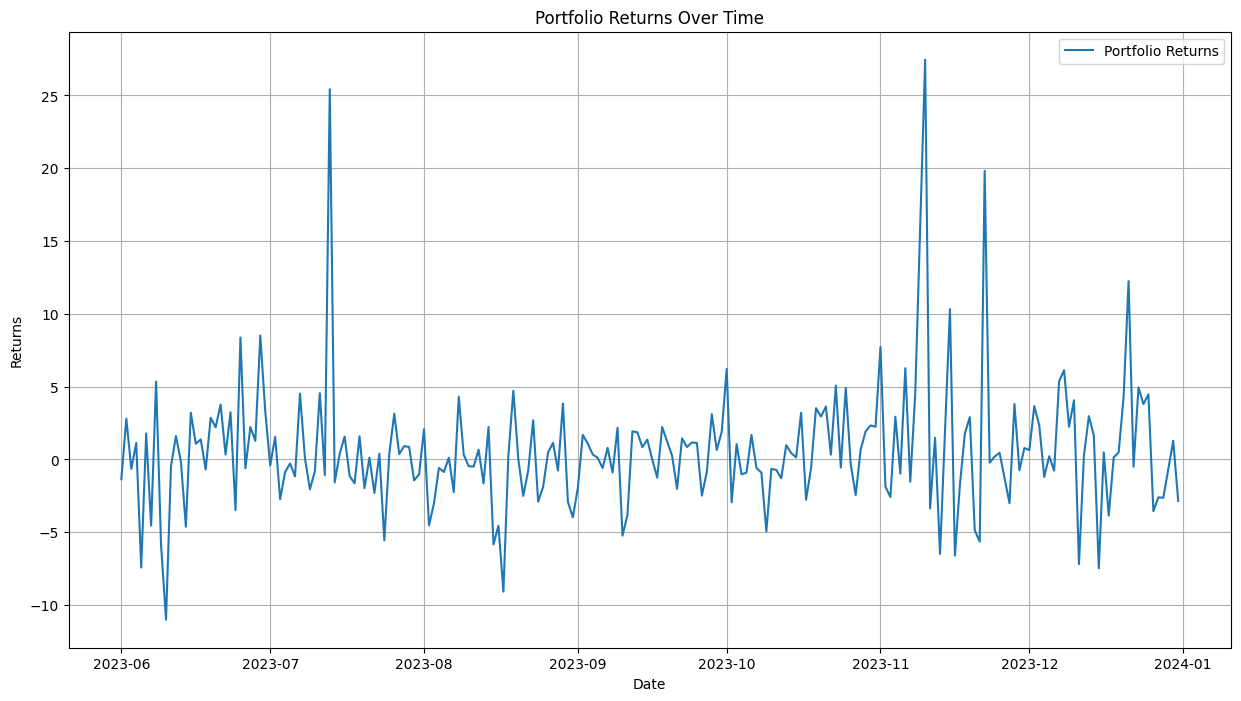

In [142]:
plt.figure(figsize=(15, 8))
plt.plot(portfolio_returns.keys(), portfolio_returns.values(), label='Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Portfolio Returns Over Time')
plt.legend()
plt.grid(True)
plt.show()

#### Transaction cost 계산

$$
TC_t = \sum_{i=1}^{N} T_i \left| x_{i,t} - x_{i,t-1}^+ \right|
$$

In [172]:
# 거래 비용을 계산하는 함수를 정의
def calculate_transaction_costs(weights, prev_weights, transaction_cost_rate):
    transaction_costs = 0
    for i in range(len(weights)):
        transaction_costs += transaction_cost_rate * abs(weights[i] - prev_weights[i])
    return transaction_costs

# 각 날짜에 대한 총 거래 비용을 저장할 딕셔너리를 초기화
total_transaction_costs = {}

# 거래 비용 비율을 설정. 50bps는 0.005로 변환 => 일별 데이터 고려
transaction_cost_rate = 0.005

# 이전 날짜의 가중치를 초기화, 첫 날 가중치 = 0
prev_weights = [0] * len(Object[next(iter(Object))])

# 각 날짜에 대해 거래 비용을 계산
for date in sorted(Object.keys()):
    current_weights = Object[date]
    transaction_costs = calculate_transaction_costs(current_weights, prev_weights, transaction_cost_rate)
    total_transaction_costs[date] = transaction_costs
    prev_weights = current_weights  # 다음 루프를 위해 현재 가중치를 이전 가중치로 업데이트


total_transaction_costs


{Timestamp('2023-06-01 00:00:00'): 0.005,
 Timestamp('2023-06-02 00:00:00'): 2.2080762803513167e-05,
 Timestamp('2023-06-03 00:00:00'): 6.353646350113742e-06,
 Timestamp('2023-06-04 00:00:00'): 1.4775948050547275e-05,
 Timestamp('2023-06-05 00:00:00'): 1.6488539675405485e-05,
 Timestamp('2023-06-06 00:00:00'): 2.0909352848570568e-05,
 Timestamp('2023-06-07 00:00:00'): 3.341727898101574e-05,
 Timestamp('2023-06-08 00:00:00'): 5.7265153618886276e-05,
 Timestamp('2023-06-09 00:00:00'): 2.7960089994731197e-05,
 Timestamp('2023-06-10 00:00:00'): 0.00013096391016593516,
 Timestamp('2023-06-11 00:00:00'): 0.00010828661745301907,
 Timestamp('2023-06-12 00:00:00'): 0.00010178415233924103,
 Timestamp('2023-06-13 00:00:00'): 0.0031743238358888388,
 Timestamp('2023-06-14 00:00:00'): 0.0015031244237788451,
 Timestamp('2023-06-15 00:00:00'): 0.0014842817794130134,
 Timestamp('2023-06-16 00:00:00'): 5.6146121603826334e-05,
 Timestamp('2023-06-17 00:00:00'): 4.613462841925727e-05,
 Timestamp('2023-06-

##### 블랙리터만 포트폴리오 기대 수익률 재계산

In [177]:
portfolio_returns2 = {}

for date in rolling_cov_matrices.keys():
    date_str = date.strftime('%Y-%m-%d')  # 날짜를 문자열로 변환
    optimal_weights = Object[date]

    # asset_returns는 딕셔너리 형태이므로, values()를 사용해 실제 수익률 값만 추출
    asset_returns = list(returns_dict[date_str].values())

    # 포트폴리오 수익률 계산
    portfolio_return = np.dot(optimal_weights, asset_returns)
    portfolio_return2 = portfolio_return - total_transaction_costs[date]
    portfolio_returns2[date] = portfolio_return2

# 포트폴리오 수익률 결과 확인
portfolio_returns2

{Timestamp('2023-06-01 00:00:00'): -1.3601622806834228,
 Timestamp('2023-06-02 00:00:00'): 2.8081222512850297,
 Timestamp('2023-06-03 00:00:00'): -0.6475175514987116,
 Timestamp('2023-06-04 00:00:00'): 1.133289617882103,
 Timestamp('2023-06-05 00:00:00'): -7.420018276084228,
 Timestamp('2023-06-06 00:00:00'): 1.781668964445254,
 Timestamp('2023-06-07 00:00:00'): -4.542765425809803,
 Timestamp('2023-06-08 00:00:00'): 5.3448552485138805,
 Timestamp('2023-06-09 00:00:00'): -5.87411821266838,
 Timestamp('2023-06-10 00:00:00'): -11.006481328533598,
 Timestamp('2023-06-11 00:00:00'): -0.4763786426671503,
 Timestamp('2023-06-12 00:00:00'): 1.6105613054016268,
 Timestamp('2023-06-13 00:00:00'): -0.1494470233598047,
 Timestamp('2023-06-14 00:00:00'): -4.623851330737055,
 Timestamp('2023-06-15 00:00:00'): 3.207002594465617,
 Timestamp('2023-06-16 00:00:00'): 1.077045149875483,
 Timestamp('2023-06-17 00:00:00'): 1.3777097743447162,
 Timestamp('2023-06-18 00:00:00'): -0.6856468690559717,
 Timestam

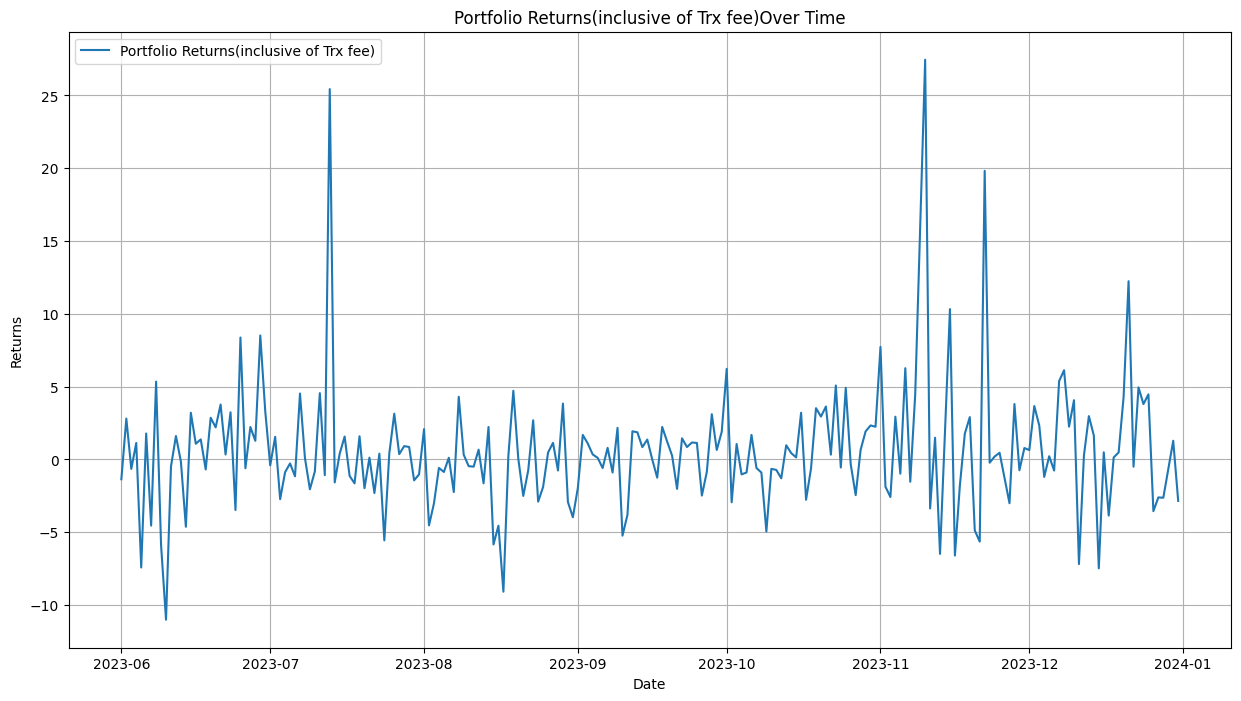

In [178]:
plt.figure(figsize=(15, 8))
plt.plot(portfolio_returns2.keys(), portfolio_returns2.values(), label='Portfolio Returns(inclusive of Trx fee)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Portfolio Returns(inclusive of Trx fee)Over Time')
plt.legend()
plt.grid(True)
plt.show()

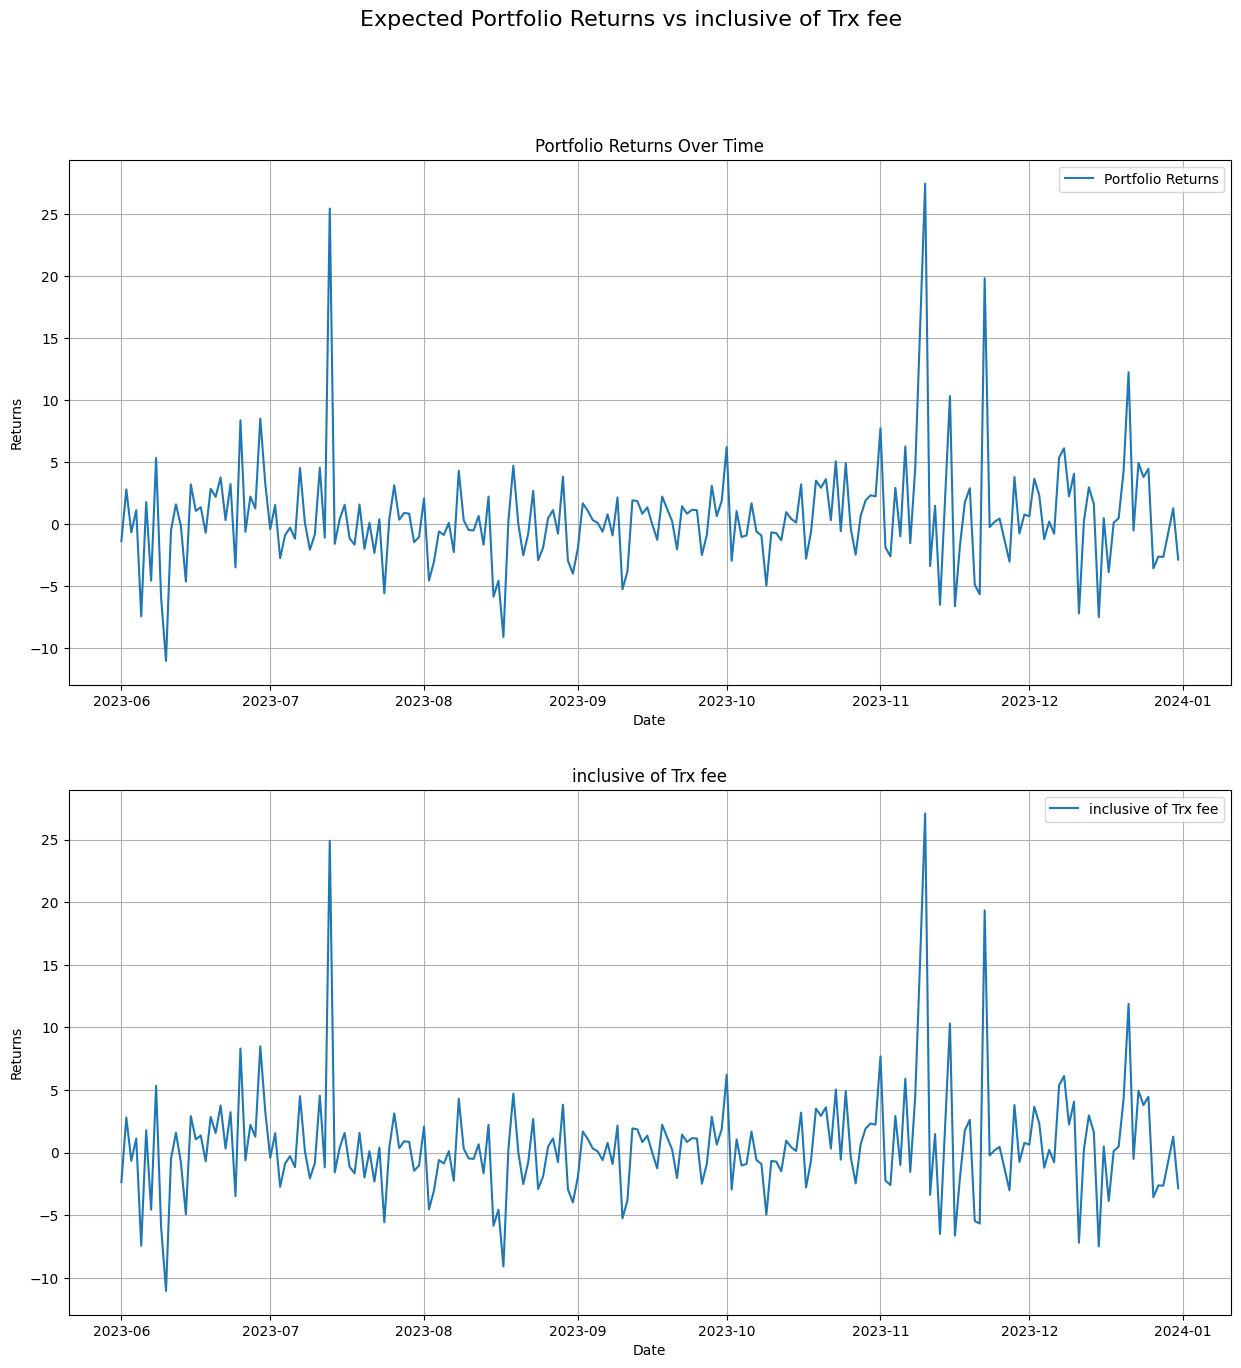

In [157]:
# 그래프 그릴 서브플롯 설정
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
fig.suptitle('Expected Portfolio Returns vs inclusive of Trx fee', fontsize=16)

# Portfolio Returns 그래프
axes[0].plot(portfolio_returns.keys(), portfolio_returns.values(), label='Portfolio Returns')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Returns')
axes[0].set_title('Portfolio Returns Over Time')
axes[0].legend()
axes[0].grid(True)

# Sharpe Ratio 그래프
axes[1].plot(portfolio_returns2.keys(), portfolio_returns2.values(), label='inclusive of Trx fee')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Returns')
axes[1].set_title('inclusive of Trx fee')
axes[1].legend()
axes[1].grid(True)

#### 차이 확인

In [188]:
# 각 날짜별로 원래 포트폴리오 수익률과 거래 비용을 고려한 포트폴리오 수익률의 차이를 계산합니다.
difference_in_returns = {}
for date in rolling_cov_matrices.keys():
    # 원래 포트폴리오 수익률에서 거래 비용을 고려한 포트폴리오 수익률을 뺍니다.
    difference_in_returns[date] = portfolio_returns[date] - portfolio_returns2[date]

# 차이 결과 확인
difference_in_returns

{Timestamp('2023-06-01 00:00:00'): 0.004999999999999893,
 Timestamp('2023-06-02 00:00:00'): 2.2080762803522447e-05,
 Timestamp('2023-06-03 00:00:00'): 6.353646350154563e-06,
 Timestamp('2023-06-04 00:00:00'): 1.4775948050438359e-05,
 Timestamp('2023-06-05 00:00:00'): 1.648853967584074e-05,
 Timestamp('2023-06-06 00:00:00'): 2.090935284848605e-05,
 Timestamp('2023-06-07 00:00:00'): 3.341727898131808e-05,
 Timestamp('2023-06-08 00:00:00'): 5.726515361903495e-05,
 Timestamp('2023-06-09 00:00:00'): 2.7960089994394366e-05,
 Timestamp('2023-06-10 00:00:00'): 0.00013096391016631515,
 Timestamp('2023-06-11 00:00:00'): 0.00010828661745304613,
 Timestamp('2023-06-12 00:00:00'): 0.00010178415233919047,
 Timestamp('2023-06-13 00:00:00'): 0.003174323835888837,
 Timestamp('2023-06-14 00:00:00'): 0.0015031244237784236,
 Timestamp('2023-06-15 00:00:00'): 0.0014842817794131768,
 Timestamp('2023-06-16 00:00:00'): 5.6146121603761756e-05,
 Timestamp('2023-06-17 00:00:00'): 4.6134628419292056e-05,
 Timesta

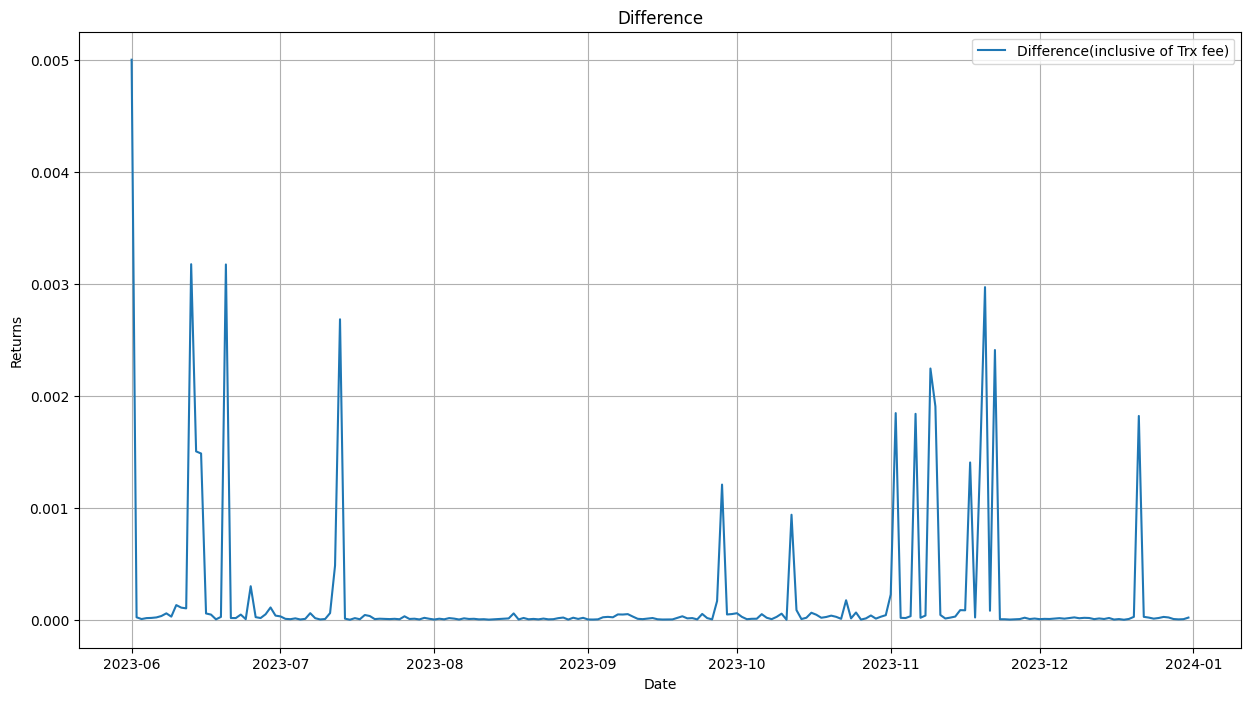

In [189]:
plt.figure(figsize=(15, 8))
plt.plot(difference_in_returns.keys(), difference_in_returns.values(), label='Difference(inclusive of Trx fee)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Difference')
plt.legend()
plt.grid(True)
plt.show()

#### 평균 수익률과 표준편차 계산

In [292]:
# 포트폴리오 수익률 리스트로 변환
portfolio_return_values = list(portfolio_returns.values())

# 포트폴리오의 평균 수익률 및 표준편차 계산
average_return = np.mean(portfolio_return_values)
stdev_return = np.std(portfolio_return_values)
average_return, stdev_return

(0.6123402109936379, 4.418941530552994)

#### 포트폴리오 예상 수익률, Sharpe ratio, 포트폴리오 표준편차

$ \text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p} $

In [297]:
# returns 데이터프레임을 딕셔너리로 변환하고, 날짜를 문자열 형식으로 변환
returns_dict = {date.strftime('%Y-%m-%d'): values for date, values in returns.to_dict(orient='index').items()}

portfolio_returns = {}
sharpe_ratios = {}
stdev_returns = {}
for date in rolling_cov_matrices.keys():
    date_str = date.strftime('%Y-%m-%d')  # 날짜를 문자열로 변환
    optimal_weights = Object[date]

    # asset_returns는 딕셔너리 형태이므로, values()를 사용해 실제 수익률 값만 추출
    asset_returns = list(returns_dict[date_str].values())

    # 포트폴리오 수익률 계산
    portfolio_return = np.dot(optimal_weights, asset_returns)
    portfolio_returns[date] = portfolio_return

    # 날짜별 포트폴리오 표준편차 계산
    stdev_return = np.std(list(portfolio_returns.values()))
    stdev_returns[date] = stdev_return

    # 날짜별 Sharpe Ratio 계산
    rf_rate = t_bill_dict[date_str] / 100  # 무위험 수익률을 퍼센트에서 실제 값으로 변환
    sharpe_ratio = (portfolio_return - rf_rate) / stdev_return if stdev_return != 0 else 0
    sharpe_ratios[date] = sharpe_ratio

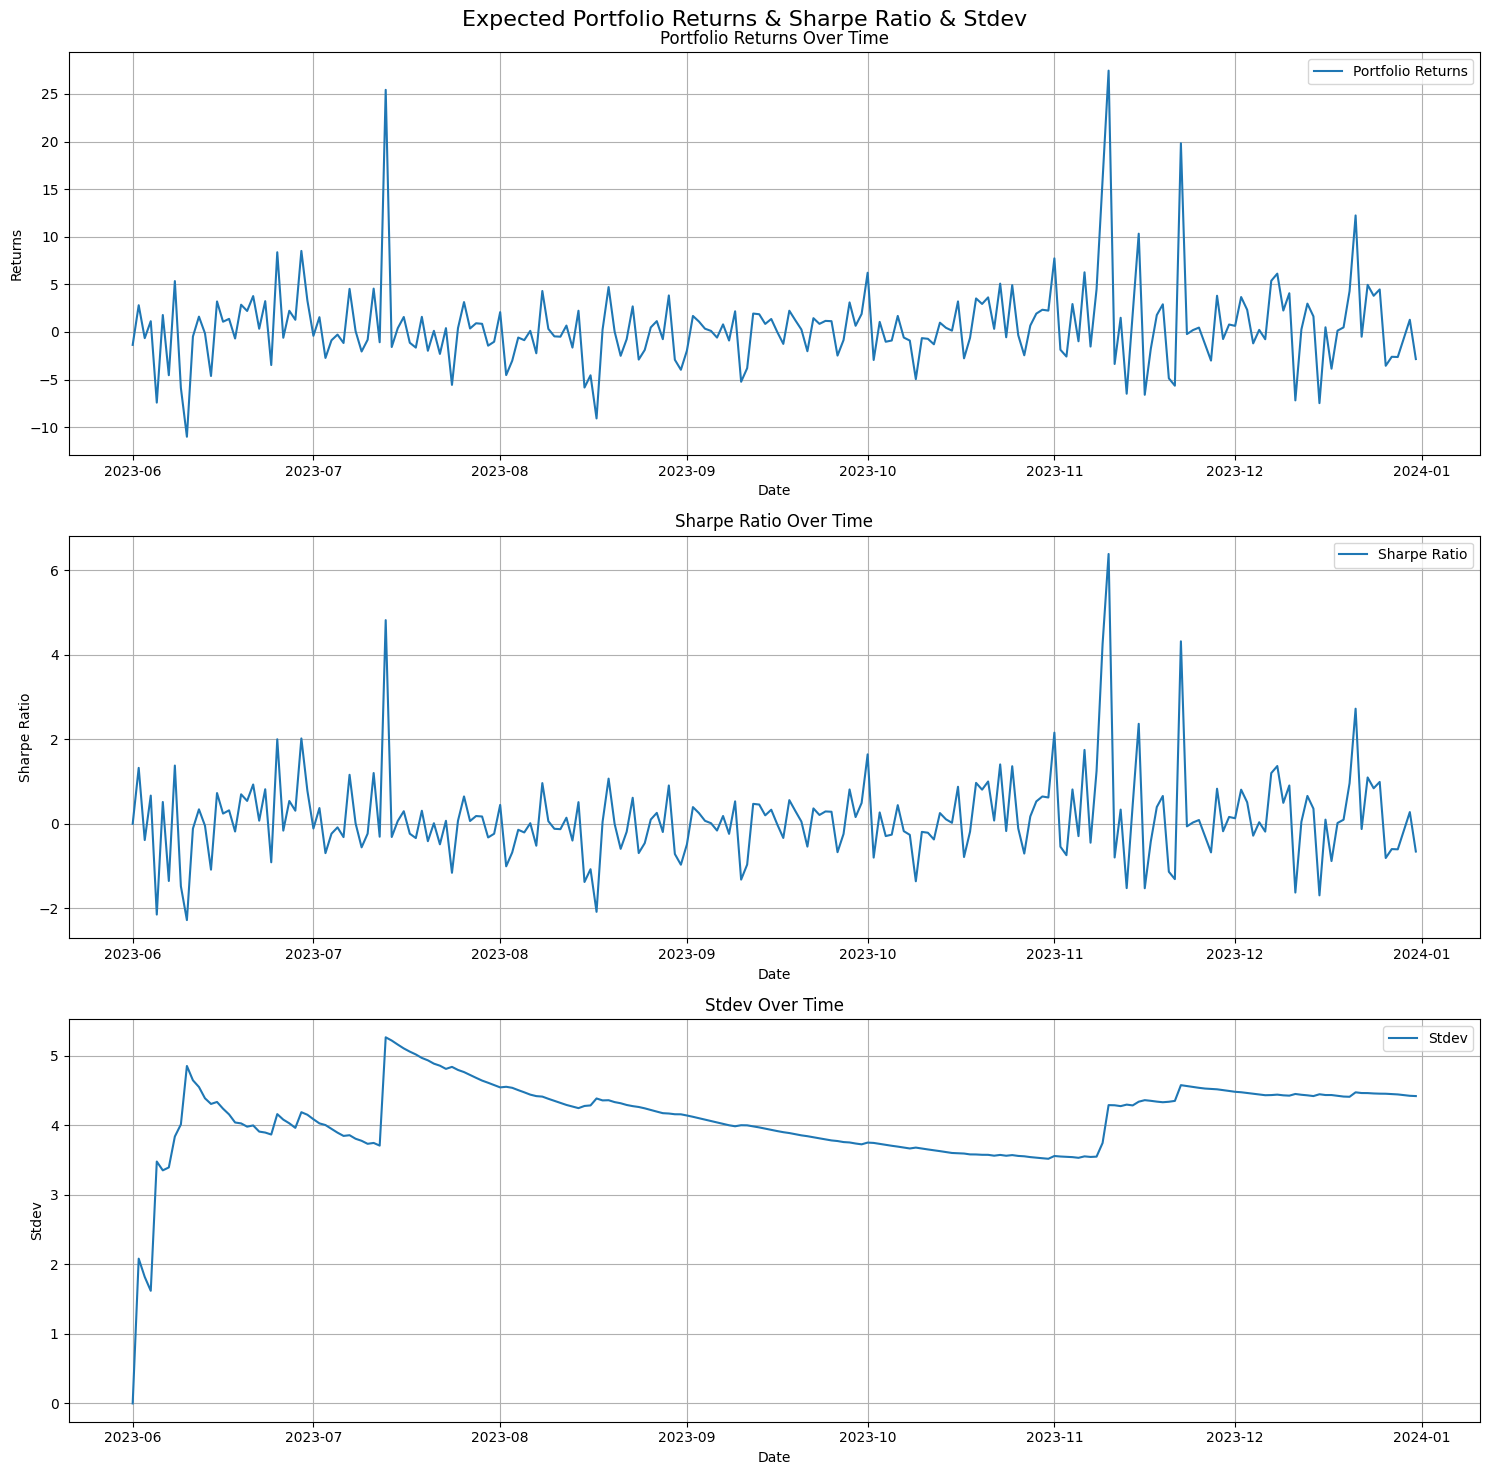

In [298]:
import matplotlib.pyplot as plt

# 그래프 그릴 서브플롯 설정
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))
fig.suptitle('Expected Portfolio Returns & Sharpe Ratio & Stdev', fontsize=16)

# Portfolio Returns 그래프
axes[0].plot(portfolio_returns.keys(), portfolio_returns.values(), label='Portfolio Returns')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Returns')
axes[0].set_title('Portfolio Returns Over Time')
axes[0].legend()
axes[0].grid(True)

# Sharpe Ratio 그래프
axes[1].plot(sharpe_ratios.keys(), sharpe_ratios.values(), label='Sharpe Ratio')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Sharpe Ratio')
axes[1].set_title('Sharpe Ratio Over Time')
axes[1].legend()
axes[1].grid(True)

# Stdev 그래프
axes[2].plot(stdev_returns.keys(), stdev_returns.values(), label='Stdev')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Stdev')
axes[2].set_title('Stdev Over Time')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()  # 서브플롯 간 간격 조절
plt.show()
